In [18]:
import numpy as np
import pandas as pd
import xarray as xr
import pickle
from hyperopt import fmin, hp, Trials, STATUS_OK
from hyperopt import atpe
import minisom
from importlib import reload
import SOM_functions as functions
reload(functions)
import warnings
from scipy.spatial import cKDTree
from scipy.stats import pearsonr
from scipy.interpolate import griddata
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
np.warnings = warnings

In [12]:
def compute_distinctness(som, best_nodes_flat, train):

    num_clusters = som.get_weights().reshape(-1, train.shape[1]).shape[0]  # Number of SOM nodes
    som_patterns = som.get_weights().reshape(num_clusters, -1)  # Flatten patterns
    
    # Compute mean patterns for each cluster
    unique_nodes, counts = np.unique(best_nodes_flat, return_counts=True)
    mean_patterns = np.array([
        np.mean(train[best_nodes_flat == node], axis=0) for node in unique_nodes
    ])
    
    # Initialize list to store distinctness values
    distinctness_values = []
    
    # Compute pairwise distinctness
    for i, r in enumerate(unique_nodes):
        for j, s in enumerate(unique_nodes):
            if r < s:  # Only compute upper triangle (symmetric matrix)
                n_r, n_s = counts[i], counts[j]
                if n_r + n_s > 0:  # Avoid division by zero
                    weight = np.sqrt((2 * n_r * n_s) / (n_r + n_s))
                    euclidean_dist = np.linalg.norm(mean_patterns[i] - mean_patterns[j])
                    distinctness_values.append(weight * euclidean_dist)
    
    return np.mean(distinctness_values)

def get_WMPC(som, best_nodes_flat, train, y):
    som_patterns = som.get_weights().reshape(y * x, -1)  # Flatten to (num_nodes, input_length)
    # Compute Pearson correlation for each day
    correlations = np.array([
        pearsonr(train[i], som_patterns[best_nodes_flat[i]])[0] for i in range(len(train))
    ])
    # Compute frequencies of each SOM node
    unique_nodes, counts = np.unique(best_nodes_flat, return_counts=True)
    node_frequencies = counts / len(train)  # Normalize to get weights
    # Create weights array: match each day with its node's frequency
    weights = np.array([node_frequencies[unique_nodes == node] for node in best_nodes_flat]).flatten()
    # Compute weighted mean correlation
    weighted_correlation = np.average(correlations, weights=weights)
    return weighted_correlation

In [16]:
data_train = np.load('ERA5/ERA5_data_train.npy')
zg500_anom = xr.open_dataset('ERA5/ERA5_coords.nc')

latitudes = zg500_anom['lat'].values  # Extract latitude array
latitudes_stacked = np.repeat(latitudes, len(zg500_anom['lon']))
latitudes_expanded = np.tile(latitudes_stacked, (data_train.shape[0], 1))
lat_weights = np.sqrt(np.cos(np.deg2rad(latitudes_expanded)))
weighted_data = data_train * lat_weights
input_len = weighted_data.shape[1]

grid_sizes = range(2, 11)  # Testing grid sizes from 2x1 to 10x1
sigma = 0.78
learning_rate = 0.00995
cluster_distances = []
correlations = []

# Run each grid size 5 times
for grid_size in grid_sizes:
    print(grid_size)
    dist_list = []
    wm_pc_list = []

    for _ in range(5):
        x = 1  # columns
        y = grid_size
        som = functions.train_som(weighted_data, x, y, input_len, sigma, learning_rate, 50000)

        best_nodes = np.array([som.winner(x) for x in weighted_data]) 
        best_nodes_flat = np.array([i * x + j for i, j in best_nodes])  

        # Calculate WMPC (weighted mean pattern correlation)
        WMPC = get_WMPC(som, best_nodes_flat, weighted_data, y)
        wm_pc_list.append(WMPC)

        # Calculate distinctness
        dist = compute_distinctness(som, best_nodes_flat, weighted_data)
        dist_list.append(dist)

    # Calculate the average for each grid size after 5 runs
    avg_wmpc = np.mean(wm_pc_list)
    avg_dist = np.mean(dist_list)

    correlations.append(avg_wmpc)
    cluster_distances.append(avg_dist)

2
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 41367.63179212038
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 41371.884940946744
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 41373.857473665244
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 41387.26356143196
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 41384.728383927504
3
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 40203.2045143456
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 40224.13352763201
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 40197.67662804898
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 40210.1997796135
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 40189.29945185156
4
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 39470.49838227279
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 39445.533748791146
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 qua

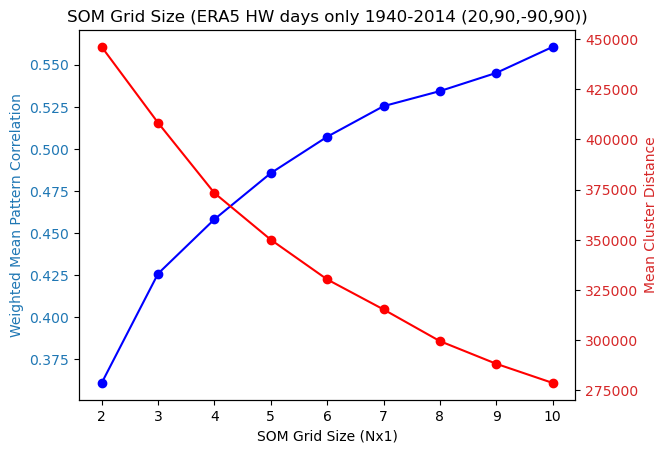

In [19]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('SOM Grid Size (Nx1)')
ax1.set_ylabel('Weighted Mean Pattern Correlation', color='tab:blue')
ax1.plot(grid_sizes, correlations, 'bo-', label='Mean Correlation')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Mean Cluster Distance', color='tab:red')
ax2.plot(grid_sizes, cluster_distances, 'ro-', label='Mean Cluster Distance')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('SOM Grid Size (ERA5 HW days only 1940-2014 (20,90,-90,90))')
plt.savefig('choosing_grid_ERA5.png')
plt.show()

In [21]:
print(correlations)
print(cluster_distances)

[0.36105677295624894, 0.425943893344073, 0.458221844117105, 0.4856293196038675, 0.5072303260970036, 0.5253991164235448, 0.5343395236541866, 0.5451400635523809, 0.5605773240280383]
[446117.8157099967, 408312.72678962804, 373310.4986011782, 350041.45894754457, 330265.10526302364, 315302.2442980667, 299510.3805820943, 288214.55752768717, 278680.3097892455]
